In [1]:
%autosave 0

Autosave disabled


In [3]:
# Remove WARNING from tensorflow
# I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. 
# You may see slightly different numerical results due to floating-point round-off errors from different 
# computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

# pretrained model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

Theory is here [https://cs231n.github.io/](https://cs231n.github.io/)

Reading data with `ImageDataGenerator`

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Target size - the size of images for the model. Start with the small size to save time. Batch size -> how many images at once we pass to the model. Each image will be converted by the convolutional layers(filters) into a vector.

In [11]:
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train/', 
                              target_size=(150, 150), 
                                batch_size=32)

Found 3068 images belonging to 10 classes.


In [15]:
!ls -l clothing-dataset-small/train

total 260
drwxrwsr-x 2 jovyan jovyan 20480 Nov 16 03:36 dress
drwxrwsr-x 2 jovyan jovyan 12288 Nov 16 03:36 hat
drwxrwsr-x 2 jovyan jovyan 36864 Nov 16 03:36 longsleeve
drwxrwsr-x 2 jovyan jovyan 20480 Nov 16 03:36 outwear
drwxrwsr-x 2 jovyan jovyan 36864 Nov 16 03:36 pants
drwxrwsr-x 2 jovyan jovyan 20480 Nov 16 03:36 shirt
drwxrwsr-x 2 jovyan jovyan 20480 Nov 16 03:36 shoes
drwxrwsr-x 2 jovyan jovyan 20480 Nov 16 03:36 shorts
drwxrwsr-x 2 jovyan jovyan 12288 Nov 16 03:36 skirt
drwxrwsr-x 2 jovyan jovyan 65536 Nov 16 03:36 t-shirt


In [14]:
# same as folders in the train directory
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [19]:
# We can iterate through train_ds with next. It returns a numpy array with batch of images arrays and target label
# X[0] -> first image with the shape (150, 150, 3), where 3 is a RGB channels
X, y = next(train_ds)
X.shape, X[0].shape

(32, 150, 150, 3)

In [20]:
X[0].shape

(150, 150, 3)

In [21]:
# y -> 32 labels for each image in the batch, 10 - one hot encoded 10 labels
y.shape

(32, 10)

In [22]:
y[0] # 9 -> t-shirt

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [24]:
y[4] # 2 -> longsleve

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Convert a validation set with image generator

In [27]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', 
                              target_size=(150, 150), 
                                batch_size=32,
                                shuffle=False) # by default it shuffles images. 
# In the train set we need to do shuffle, it's ok not to shuffle in validation

Found 341 images belonging to 10 classes.


####  Train the model

__*Base model: Xception*__

*Convolutional Layers* are __bottom__

*Dense layers* are __top__

Dense layers are very specific to the image data set. So, we won't include the dense layers from the pre-trained model into our model. To do this we use parameter: 
```python
include_top = False
```

We don't want to train our base model, instead we want to use its convolutional layers. To prevent the training:
```python
base_model.trainable = False
```

In [28]:
base_model = Xception(
                weights='imagenet', 
                include_top=False,
                input_shape=(150, 150, 3)
)
# use conv.layers of Xception
base_model.trainable = False

2023-11-17 19:56:20.930135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-17 19:56:20.937203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-17 19:56:20.937828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-17 19:56:20.938961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

83683744/83683744 [==============================] - 2s 0us/step


Create new dense layers

In [30]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs)

outputs = base

model = keras.Model(inputs, outputs)

In [34]:
preds = model.predict(X)

1/1 [==============================] - 0s 28ms/step


In [35]:
preds.shape # it's not vector yet, image is converted to the shape 5, 5, 2048

(32, 5, 5, 2048)

The shape of predictions after filters in convolutional layers is 3D - (5, 5, 2048). We need to convert in into 1D vector representation. To do this we take a 2D 5x5 and calculate an average and save its result. This calls __pooling__. In our case we perform __2D average pooling__.

In [36]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

# add pooling
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

# shortcut with functional style
# vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = vectors # outputs of conv.layers

model = keras.Model(inputs, outputs)

# predict and check if the shape is correct 32 vectors of size 2048
preds = model.predict(X)
preds.shape

1/1 [==============================] - 1s 878ms/step


(32, 2048)

#### Dense Layers

Now we need to add Dense Layers.
```python
outputs = keras.layers.Dense(10)(vectors)
```
10 - number of classes in out classification. 

After adding the dense layers the shape of predictions should be 32 images x 10 classes.

In [37]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs) # add training = False?

# add pooling
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

# shortcut with functional style
# vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors) # outputs of conv.layers

model = keras.Model(inputs, outputs)

# predict and check if the shape is correct 32 vectors of size 2048
preds = model.predict(X)
preds.shape

1/1 [==============================] - 1s 613ms/step


(32, 10)

In [39]:
preds[0] # random numbers, because we didn't train the model

array([ 0.14490634,  0.28693748,  0.41197726, -0.39983645, -1.0731734 ,
        0.2735745 , -0.53589606,  0.2838724 ,  0.52214724,  0.02979422],
      dtype=float32)

Train the model.

First thing we need -> an optimizer.

2. Specify a loss function. loss function -> 
    * for multiclass `CategoricalCrossentropy`, 
    * for binary - `BinaryCrossentropy`, 
    * for regression `MeanAbsoluteError`
    
Logits - the raw output of dense layer before we apply an activation function (`softmax` in our case). If we use the loss function with its default parameter `from_logits=False`, we need to specify an activation function in the Dense Layer
```python
outputs = keras.layers.Dense(10, activation='softmax')(vectors)
```

In [41]:
learning_rate = 0.01 # like eta in xgboost
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# loss function -> for multiclass CategoricalCrossentropy, for binary - BinaryCrossentropy, for regression MeanAbsoluteError
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# fit the model. 1 epoch goes through ALL batches 
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 135ms/step - loss: 0.1760 - accuracy: 0.9390 - val_loss: 1.3415 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1594 - accuracy: 0.9518 - val_loss: 1.2527 - val_accuracy: 0.7801
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1405 - accuracy: 0.9527 - val_loss: 1.2277 - val_accuracy: 0.8152
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.1122 - accuracy: 0.9645 - val_loss: 1.3534 - val_accuracy: 0.7977
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.0590 - accuracy: 0.9837 - val_loss: 1.5760 - val_accuracy: 0.7918
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 1.6834 - val_accuracy: 0.7566
Epoch 7/10
96/96 [==============================] - 12s 124ms/step - loss: 0.1252 - accuracy: 0.9645 - val_loss: 1.6736 - val_accuracy: 0.7801

The model save the results in the `History` object. To access those results `history.history`

In [42]:
history.history

{'loss': [0.17596565186977386,
  0.15942643582820892,
  0.14050164818763733,
  0.11219605803489685,
  0.059008605778217316,
  0.058069657534360886,
  0.1252395510673523,
  0.1010747179389,
  0.04571126401424408,
  0.04952599108219147],
 'accuracy': [0.9390482306480408,
  0.9517601132392883,
  0.9527379274368286,
  0.9644719958305359,
  0.9837027192115784,
  0.9814211130142212,
  0.9644719958305359,
  0.9654498100280762,
  0.9853324890136719,
  0.9833768010139465],
 'val_loss': [1.3414636850357056,
  1.252655029296875,
  1.2276936769485474,
  1.3534268140792847,
  1.576048493385315,
  1.6834138631820679,
  1.6736247539520264,
  1.8710516691207886,
  1.968308448791504,
  1.5622413158416748],
 'val_accuracy': [0.7829912304878235,
  0.7800586223602295,
  0.8152492642402649,
  0.7976539731025696,
  0.7917888760566711,
  0.7565982341766357,
  0.7800586223602295,
  0.803519070148468,
  0.7917888760566711,
  0.803519070148468]}

In [43]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

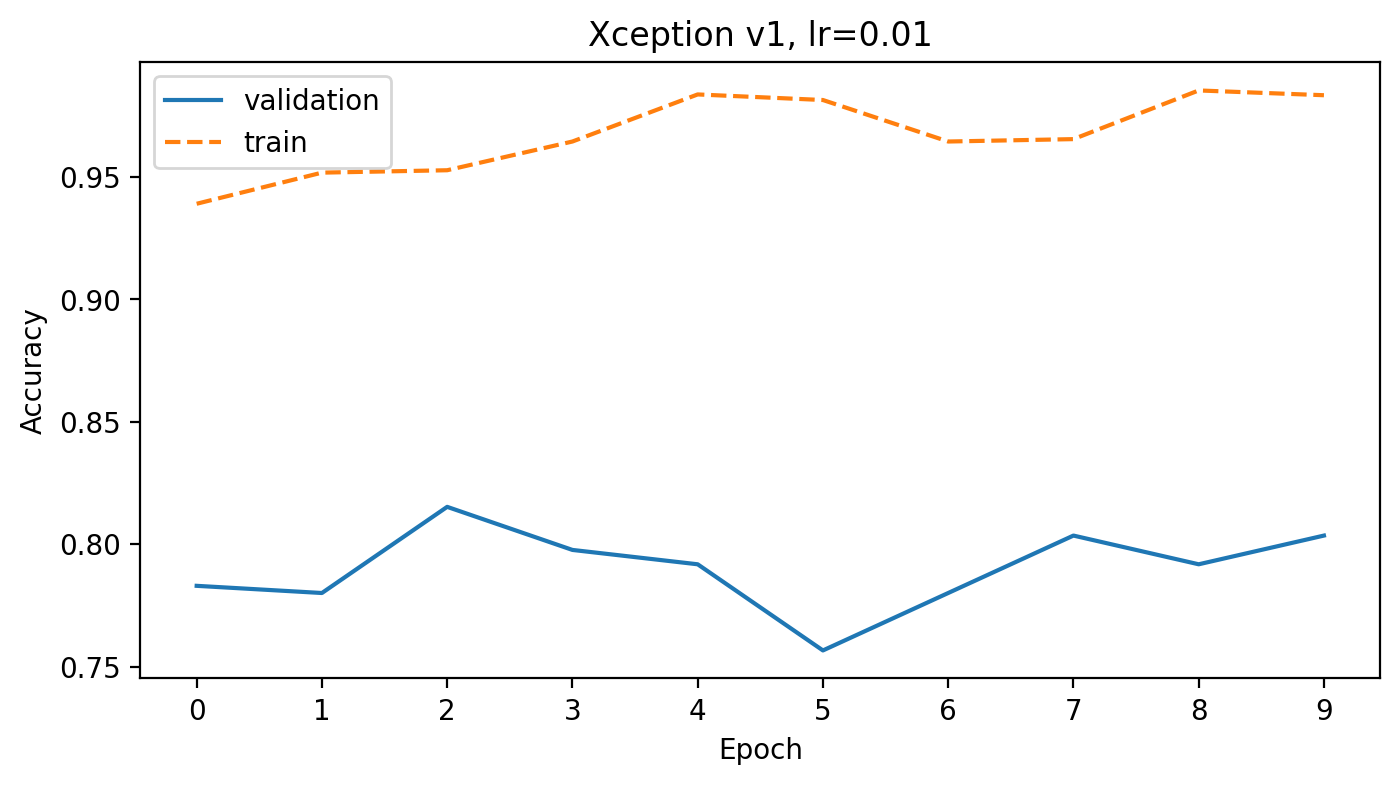

In [44]:
plt.figure(figsize=(8, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, linestyle='solid', label='validation')
plt.plot(epochs, train, linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()
#plt.savefig('xception_v1_0_01.svg')
plt.show()

Train with `base = base_model(inputs, training = False)` 

Epoch 1/10
96/96 [==============================] - 15s 131ms/step - loss: 3.6879 - accuracy: 0.6626 - val_loss: 2.5770 - val_accuracy: 0.7331
Epoch 2/10
96/96 [==============================] - 12s 122ms/step - loss: 1.1313 - accuracy: 0.8318 - val_loss: 1.6760 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5382 - accuracy: 0.8941 - val_loss: 1.8842 - val_accuracy: 0.7683
Epoch 4/10
96/96 [==============================] - 12s 121ms/step - loss: 0.2911 - accuracy: 0.9296 - val_loss: 1.7023 - val_accuracy: 0.7859
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1508 - accuracy: 0.9573 - val_loss: 1.7280 - val_accuracy: 0.8035
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.0788 - accuracy: 0.9729 - val_loss: 1.6755 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 1.7506 - val_accuracy: 0.8123

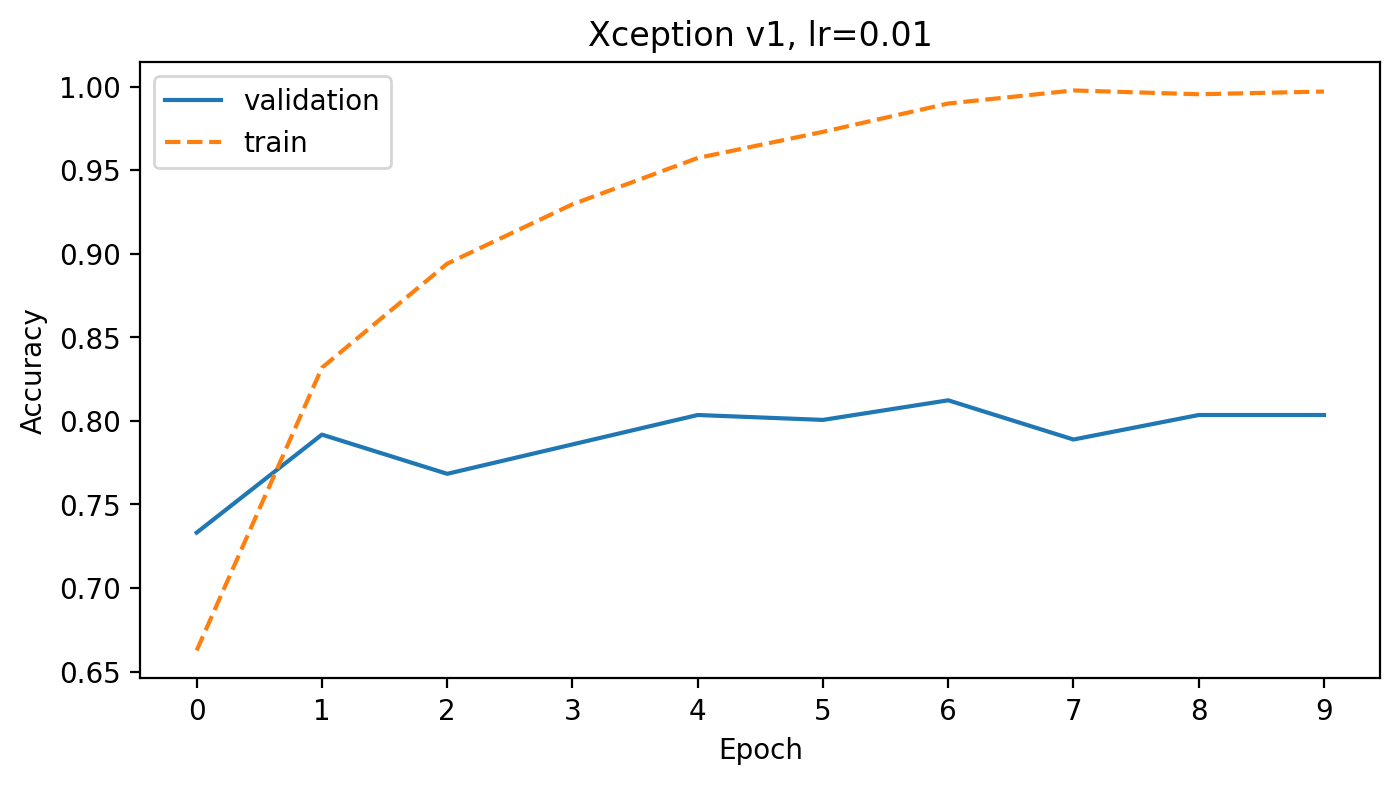

In [45]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training = False) 

# add pooling
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

# shortcut with functional style
# vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors) # outputs of conv.layers

model = keras.Model(inputs, outputs)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# fit the model. 1 epoch goes through ALL batches 
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

# plot
plt.figure(figsize=(8, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, linestyle='solid', label='validation')
plt.plot(epochs, train, linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()
#plt.savef

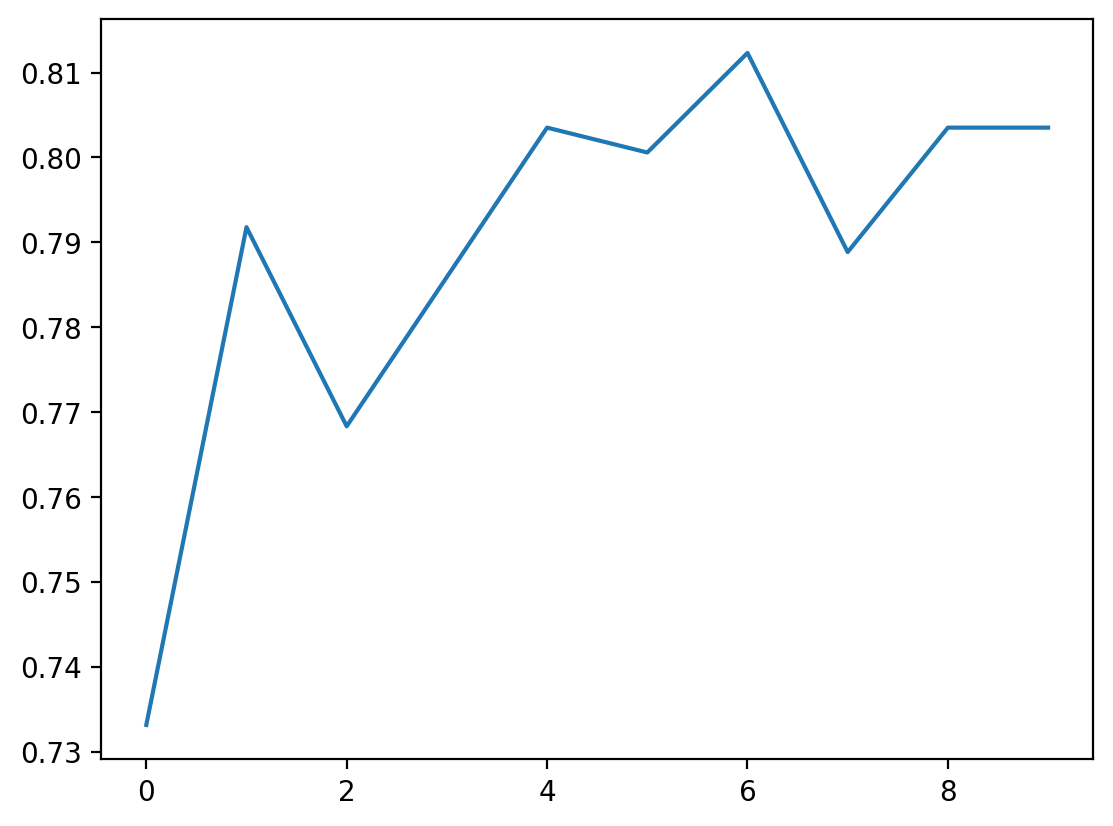

In [46]:
plt.plot(epochs, val, linestyle='solid', label='validation');

The highest val score was on epoch 6. It's overfitting anyways.

### Learning Rate tuning

__Learning rate__ -> how fast the model learns. Low rates are very effective but very slow. Learn slow, remember everything, Models with low LR underfit. The high LR -> fast learning, leanrs a lot, but forgets fast. Models with high LR tend to overfit.

In [47]:
# Function to create model
def make_model(learning_rate=0.01):
    # base (pre-trained) model
    base_model = Xception(
                    weights='imagenet', 
                    include_top=False,
                    input_shape=(150, 150, 3)
    )
    # use conv.layers of Xception
    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False) 

    # add pooling
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    outputs = keras.layers.Dense(10)(vectors) # outputs of conv.layers

    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [48]:
# Dictionary to store history with different learning rates
scores = {}

# List of learning rates
lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in lrs:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 15s 132ms/step - loss: 1.9181 - accuracy: 0.3416 - val_loss: 1.5776 - val_accuracy: 0.5249
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 1.3781 - accuracy: 0.5649 - val_loss: 1.2216 - val_accuracy: 0.6334
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 1.1371 - accuracy: 0.6392 - val_loss: 1.0463 - val_accuracy: 0.6569
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 0.9970 - accuracy: 0.6835 - val_loss: 0.9329 - val_accuracy: 0.7185
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.9058 - accuracy: 0.7102 - val_loss: 0.8586 - val_accuracy: 0.7419
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.8396 - accuracy: 0.7282 - val_loss: 0.8120 - val_accuracy: 0.7507
Epoch 7/10
96/96 [==============================] - 12s 122ms/step - loss: 0.7878 - accuracy: 0.7441 - val_loss: 0.7681 - val_accuracy:

In [49]:
import pickle

In [52]:
# save scores just in case
file_name = "lr_scores"
with open(file_name, "wb") as f_in:
    pickle.dump(scores, f_in)

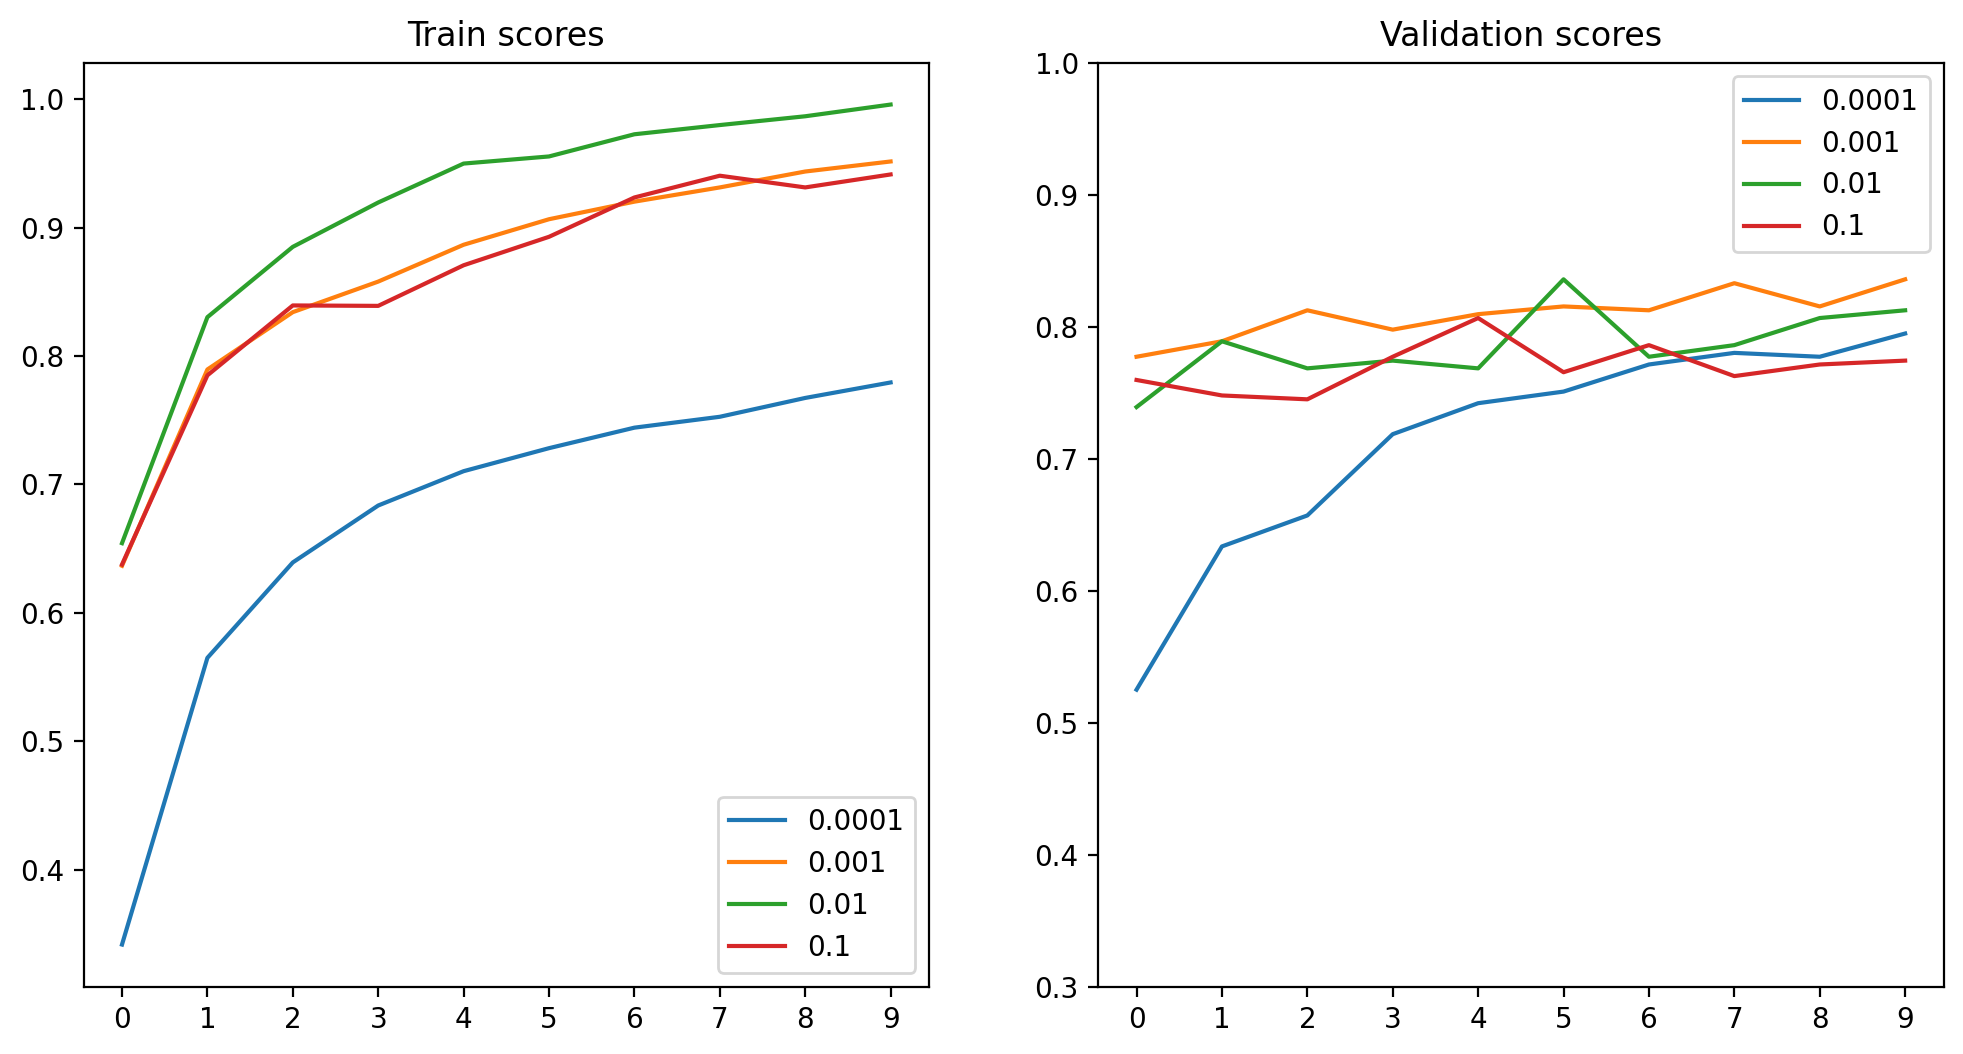

In [70]:
# plot accuracy scores for each learning rate
plt.figure(figsize=(12, 6))

plt.subplot(121)
# train scores
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()
plt.title("Train scores")

plt.subplot(122)
# train scores
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.ylim(0.3, 1)
plt.legend()
plt.title("Validation scores")

plt.show()

In [71]:
del scores[0.0001]

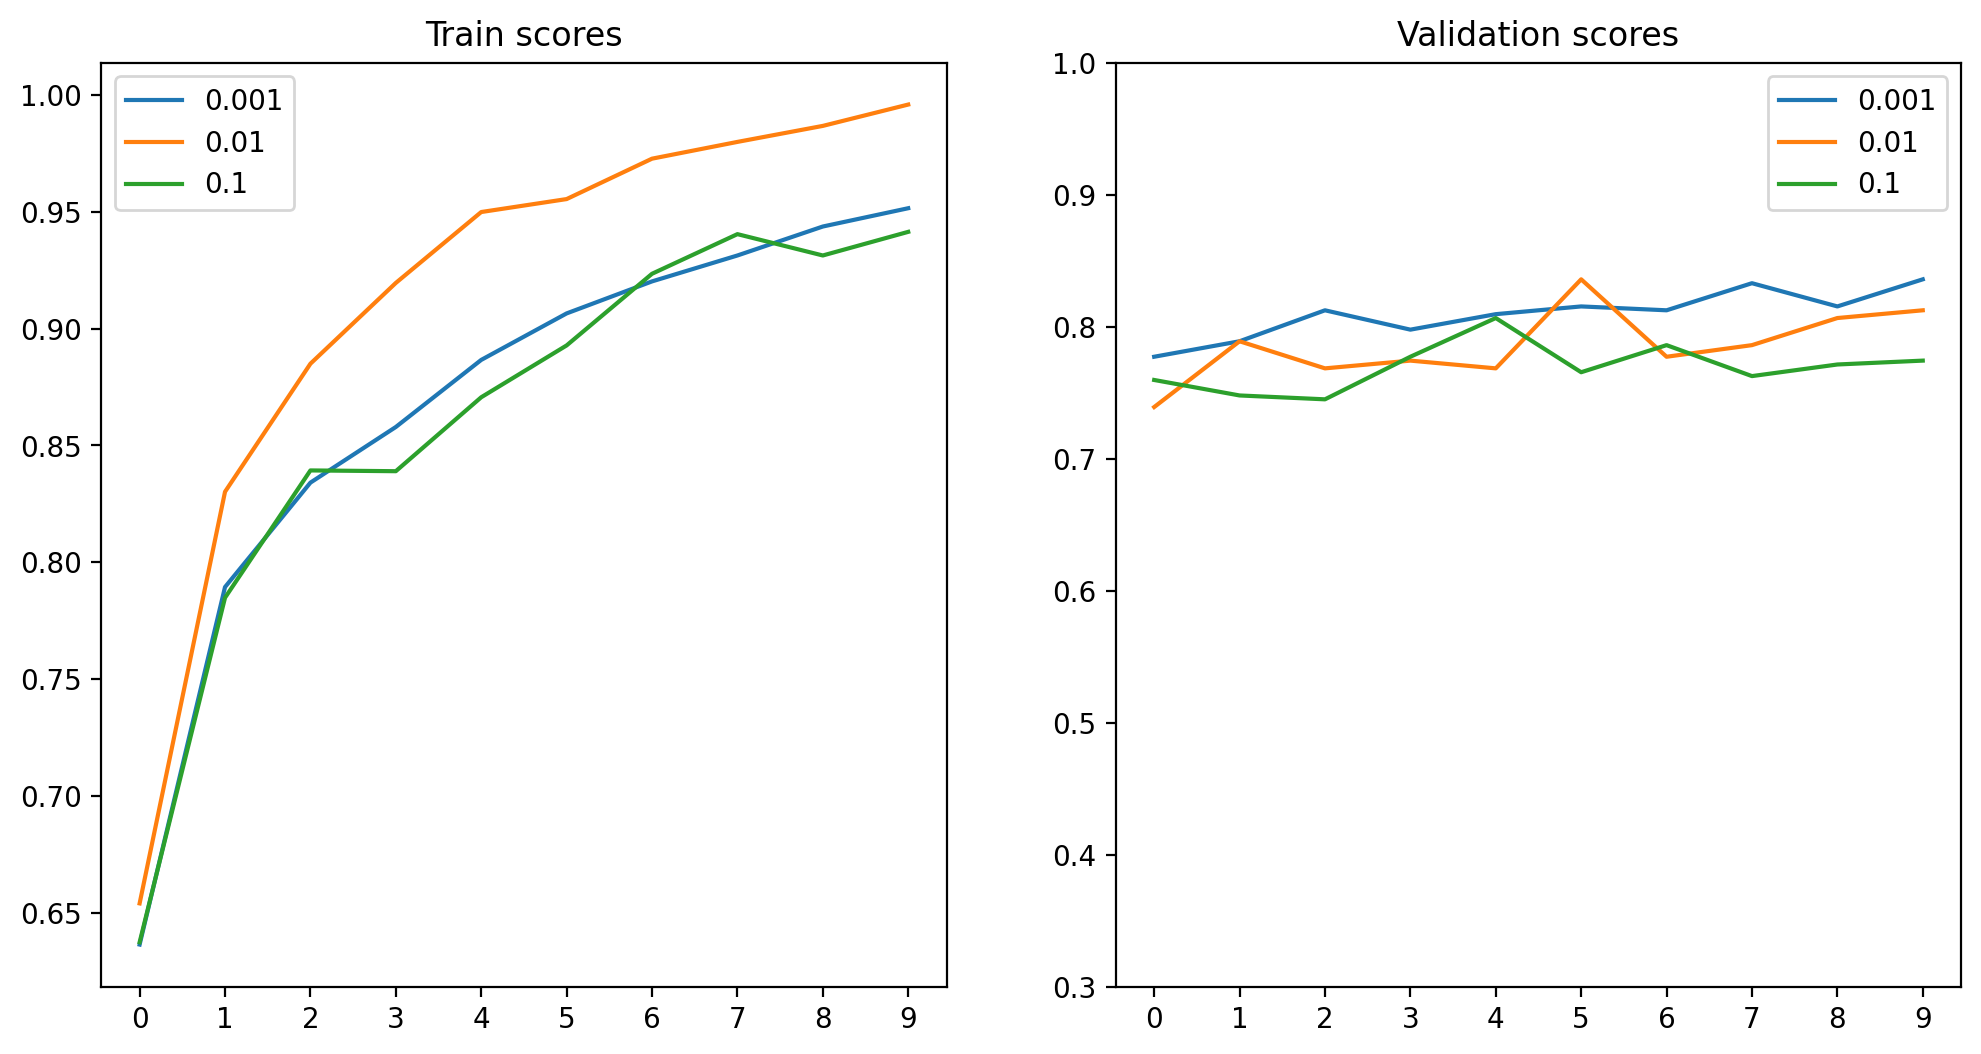

In [72]:
# plot accuracy scores for each learning rate
plt.figure(figsize=(12, 6))

plt.subplot(121)
# train scores
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()
plt.title("Train scores")

plt.subplot(122)
# train scores
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.ylim(0.3, 1)
plt.legend()
plt.title("Validation scores")

plt.show()

The best learning rate is `0.001`